# Run at A-100 GPU

Searching in :  /content/data/train
Searching in :  /content/data/train/horse
Searching in :  /content/data/train/dog
Searching in :  /content/data/train/bird
Searching in :  /content/data/train/airplane
Searching in :  /content/data/train/automobile
Searching in :  /content/data/train/deer
Searching in :  /content/data/train/truck
Searching in :  /content/data/train/cat
Searching in :  /content/data/train/frog
Searching in :  /content/data/train/ship
output_dim :  10
[1 9 6 8 7 1 2 5 8 9]
(50000, 168, 168, 3)


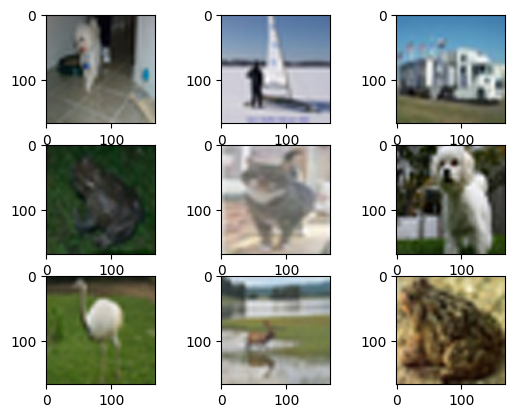

'\nModel Engineering\n'

In [1]:
'''
Data Engineering
'''

'''
D0. Custom dataset download from Auther's Google Drive
'''

!pip install --upgrade --no-cache-dir gdown

import gdown

'''
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/RichardMinsooGo/5_TF2_UCF101_video_classification.git
! git pull origin master
# ! git pull origin main
'''

# Cifar 10 dataset download from Auther's Github repository
google_path = 'https://drive.google.com/uc?id='
file_id = '18I06ymkUqKwEon4Dsb8GqkJORwPZZxLd'
output_name = 'Cifar_10.zip'
gdown.download(google_path+file_id,output_name,quiet=False)
# https://drive.google.com/file/d/18I06ymkUqKwEon4Dsb8GqkJORwPZZxLd/view?usp=sharing

'''
# Cifar 100 dataset download from Auther's Github repository
google_path = 'https://drive.google.com/uc?id='
file_id = '1QlgaDRl1rsEd4x9V3RcT07zq7bZ96Msc'
output_name = 'Cifar_100.zip'
gdown.download(google_path+file_id,output_name,quiet=False)
# https://drive.google.com/file/d/1QlgaDRl1rsEd4x9V3RcT07zq7bZ96Msc/view?usp=sharing

! rm -rf sample_data
!unzip /content/Cifar_100.zip -d /content/data
clear_output()
! rm /content/Cifar_100.zip
'''

'''
D1. Import Libraries for Data Engineering
'''
from IPython.display import clear_output
# clear_output()
from glob import glob
import random
import os
import tensorflow as tf
import numpy as np

'''
D2. Image Parsing
'''
# Unzip images
! rm -rf sample_data
!unzip /content/Cifar_10.zip -d /content/data
clear_output()
! rm /content/Cifar_10.zip

# Define parsing image function
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

IMG_SIZE = 168 # 224

# Train data parsing
X_train, Y_train = [],[]
path = "/content/data/train"
classes = os.listdir(path)
filenames = glob(path + '/*/*')
random.shuffle(filenames)
X_train = [parse_image(name) for name in filenames]
Y_train = [classes.index(name.split('/')[-2]) for name in filenames]

# Convert to numpy array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Test data parsing
X_test, Y_test = [],[]
path = "/content/data/test"
classes = os.listdir(path)
filenames = glob(path + '/*/*')
random.shuffle(filenames)
X_test = [parse_image(name) for name in filenames]
Y_test = [classes.index(name.split('/')[-2]) for name in filenames]

# Convert to numpy array
X_test = np.array(X_test)
Y_test = np.array(Y_test)


# Count output dimension
APP_FOLDER = '/content/data/train'
totalFiles = 0
output_dim = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        output_dim += 1
    for Files in files:
        totalFiles += 1

print("output_dim : ", output_dim)

'''
D3. Data Preprocessing
'''
# Normalizing
X_train, X_test = X_train / 255.0, X_test / 255.0

print(Y_train[0:10])
print(X_train.shape)

# One-Hot Encoding
# from tensorflow.keras.utils import to_categorical

# Y_train = to_categorical(Y_train, output_dim)
# Y_test = to_categorical(Y_test, output_dim)

'''
D4. EDA(? / Exploratory data analysis)
'''
import matplotlib.pyplot as plt

# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    # if you want to invert color, you can use 'gray_r'. this can be used only for MNIST, Fashion MNIST not cifar10
    # pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray_r'))

# show the figure
plt.show()

'''
Model Engineering
'''


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
num_classes = 10
input_shape = (IMG_SIZE, IMG_SIZE, 3)

In [4]:
patch_size      = (2, 2)    # 2-by-2 sized patches
dropout_rate    = 0.03      # Dropout rate
num_heads       = 8         # Attention heads
embed_dim       = 64        # Embedding dimension
num_mlp         = 256       # MLP layer size
qkv_bias        = True      # Convert embedded patches to query, key, and values with a learnable additive value
window_size     = 2         # Size of attention window
shift_size      = 1         # Size of shifting window
image_dimension = IMG_SIZE  # Initial image size

num_patch_x     = input_shape[0] // patch_size[0]
num_patch_y     = input_shape[1] // patch_size[1]

learning_rate    = 1e-3
batch_size       = 128
num_epochs       = 10
validation_split = 0.1
weight_decay     = 0.0001
label_smoothing  = 0.1

In [5]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [6]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [7]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim         = dim  # number of input dimensions
        self.num_patch   = num_patch  # number of embedded patches
        self.num_heads   = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size  = shift_size  # size of window shift
        self.num_mlp     = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


In [8]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [9]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [10]:
! pip install tensorflow_addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [11]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy")
    ],
)
"""
history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=valid_gen,
)
"""

'\nhistory = model.fit(\n    train_gen,\n    batch_size=batch_size,\n    epochs=num_epochs,\n    validation_data=valid_gen,\n)\n'

In [12]:
model_name = 'SwinTransformer'

'''
M6. Load trained model
'''

import os.path
if os.path.isfile(model_name+'.h5'):
    model.load_weights(model_name+'.h5')

'''
M7. Define getBatch Function for "model.train_on_batch"
'''
train_size = 100
test_size  = 200
STEPS      = int(len(X_train)/train_size)
VAL_STEPS  = int(len(X_test)/test_size)

import cv2

def getBatch(batch_size, train_or_val='train'):
    x_batch = []
    y_batch = []
    if train_or_val == 'train':
        idx = np.random.randint(0, len(X_train), (batch_size))

        for i in idx:
            img = cv2.resize(X_train[i], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
            x_batch.append(img)
            y_batch.append(Y_train[i])
    elif train_or_val == 'val':
        idx = np.random.randint(0, len(X_test), (batch_size))

        for i in idx:
            img = cv2.resize(X_test[i], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
            x_batch.append(img)
            y_batch.append(Y_test[i])
    else:
        print("error, please specify train or val")

    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)
    return x_batch, y_batch

# checkpoint was not used in this implementation
checkpoint = tf.train.Checkpoint(cnn=model)

'''
M8. Define Episode / each step process
'''

from tqdm import tqdm, tqdm_notebook, trange

'''
M10. Save Model
'''
model.save_weights(model_name+'.h5', overwrite=True)


<ipython-input-12-8952807dcfad>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=STEPS, desc=f"Train Epoch {epoch+1}") as pbar:


Train Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-12-8952807dcfad>:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=VAL_STEPS, desc=f"Test_ Epoch {epoch+1}") as pbar:


Test_ Epoch 10:   0%|          | 0/50 [00:00<?, ?it/s]

7/7 [==============================] - 0s 29ms/step - loss: 1.2853 - accuracy: 0.5250


ValueError: Unable to create dataset (name already exists)

In [ ]:

for epoch in range(num_epochs):

    with tqdm_notebook(total=STEPS, desc=f"Train Epoch {epoch+1}") as pbar:
        train_losses = []
        train_accuracies = []

        for s in range(STEPS):

            x_batch, y_batch = getBatch(train_size, "train")

            out      = model.train_on_batch(x_batch, y_batch)
            loss_val = out[0]
            acc      = out[1]*100
            train_losses.append(loss_val)
            train_accuracies.append(acc)

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(train_losses):.4f}) Acc: {acc:.3f} ({np.mean(train_accuracies):.3f})")

'''
M9. Model evaluation
'''
with tqdm_notebook(total=VAL_STEPS, desc=f"Test_ Epoch {epoch+1}") as pbar:
    test_losses = []
    test_accuracies = []
    for s in range(VAL_STEPS):
        x_batch_val, y_batch_val = getBatch(test_size, "val")
        evaluation = model.evaluate(x_batch_val, y_batch_val)

        loss_val= evaluation[0]
        acc     = evaluation[1]*100

        test_losses.append(loss_val)
        test_accuracies.append(acc)

        pbar.update(1)
        pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(test_losses):.4f}) Acc: {acc:.3f} ({np.mean(test_accuracies):.3f})")


<ipython-input-14-421aa7ae7e9c>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=STEPS, desc=f"Train Epoch {epoch+1}") as pbar:


Train Epoch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch 13:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:

'''
M11. Sample outputs from validation set
'''
LABELS_LIST = "airplane automobile bird cat deer dog frog horse ship truck".split(" ")

n_sample = 8
x_batch_val, y_batch_val = getBatch(n_sample, "val")

for i in range(n_sample):
    import numpy as np
    plt.imshow(x_batch_val[i])
    plt.show()
    print("pred: " + LABELS_LIST[np.argmax(model.predict(x_batch_val[i:i+1]))])
    print("acct: " + LABELS_LIST[np.argmax(y_batch_val[i])])



In [ ]:
model.save('./SWin_Transformer.h5')